In [1]:
import pandas
from scipy import signal
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,8)
import collections

In [2]:
with open('DataN.txt') as f:
    input = f.readlines()
for i in range(len(input)):
    input[i] = float(input[i].replace("\n",""))

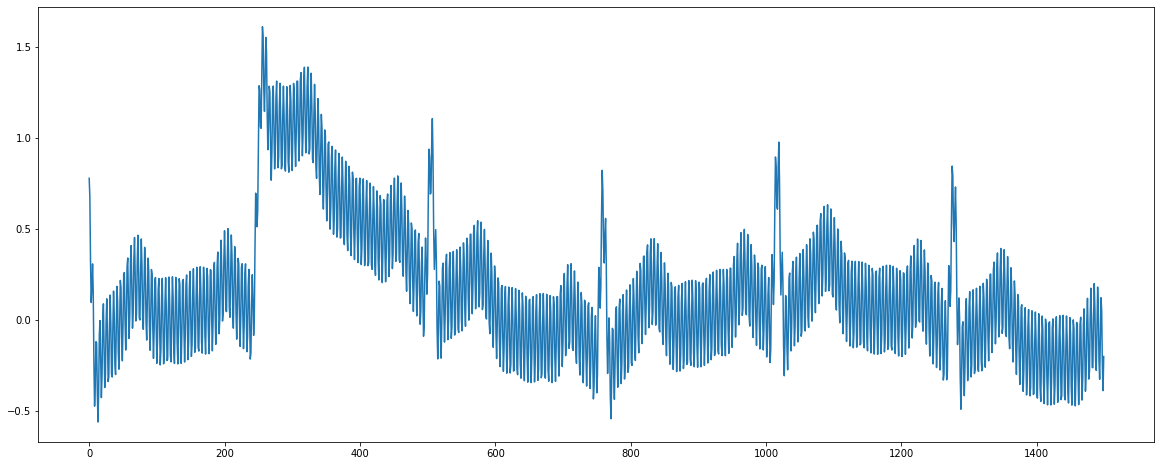

In [4]:
plt.plot(input[:1500])
plt.show()

In [84]:
def detectR(noisySignal, N, filter=True):
    filteredSignal = filterNoise(noisySignal)
    if filter:
        differentiatedSignal = differentiateSignal(filteredSignal)
    else:
        differentiatedSignal = differentiateSignal(noisySignal)
    squaredSignal = np.square(differentiatedSignal)
    smoothedSignal = getMovingAverage(squaredSignal,N)
    smoothedSignal = np.array(smoothedSignal)
    smoothedSignal[smoothedSignal < (np.nanmax(smoothedSignal)/3)] = None
    r = []
    rr = []
    i=0
    while i <len(smoothedSignal):
        if np.isnan(smoothedSignal[i]):
            i+=1
            continue
        local = []
        indices=[]
        while i<len(smoothedSignal) and not (np.isnan(smoothedSignal[i])) :
            local.append(noisySignal[i])
            indices.append(i)
            i+=1
        r.append(indices[local.index(max(local))])
        i+=1
    for i in range(1,len(r)):
        rr.append(((r[i]-r[i-1])*1000)/256)
    return r, rr
    
    
def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

def filterNoise(noisySignal):
    b_notch, a_notch = signal.iirnotch(50, 2, 256)
 
    freq, h = signal.freqz(b_notch, a_notch, fs=2*np.pi)

    outputSignal = signal.filtfilt(b_notch, a_notch, noisySignal)
    y = butter_bandpass_filter(outputSignal, 0.1, 45, 256, order=4)
    return y
def differentiateSignal(inputSignal):
    prev2 = collections.deque(inputSignal)
    prev2.rotate(2)
    prev2 = list(prev2)
    
    prev1 = collections.deque(inputSignal)
    prev1.rotate(1)
    prev1 = list(prev1)
    
    for2 = collections.deque(inputSignal)
    for2.rotate(-2)
    for2 = list(for2)
    
    for1 = collections.deque(inputSignal)
    for1.rotate(-1)
    for1 = list(for1)

    differentiated = (-1*np.array(prev2)-2*np.array(prev1)+2*np.array(for1)+1*np.array(for2))/8
    differentiated[0]=0
    differentiated[1]=0
    differentiated[-1]=0
    differentiated[-2]=0
    return differentiated
def getMovingAverage(inputSignal, window):
    moving_averages = []
    i=0
    while i < len(inputSignal) - window + 1:
  
        window_average = round(np.sum(inputSignal[
          i:i+window]) / window, 5)
      
        moving_averages.append(window_average)
      
        i += 1
  
    return (moving_averages)

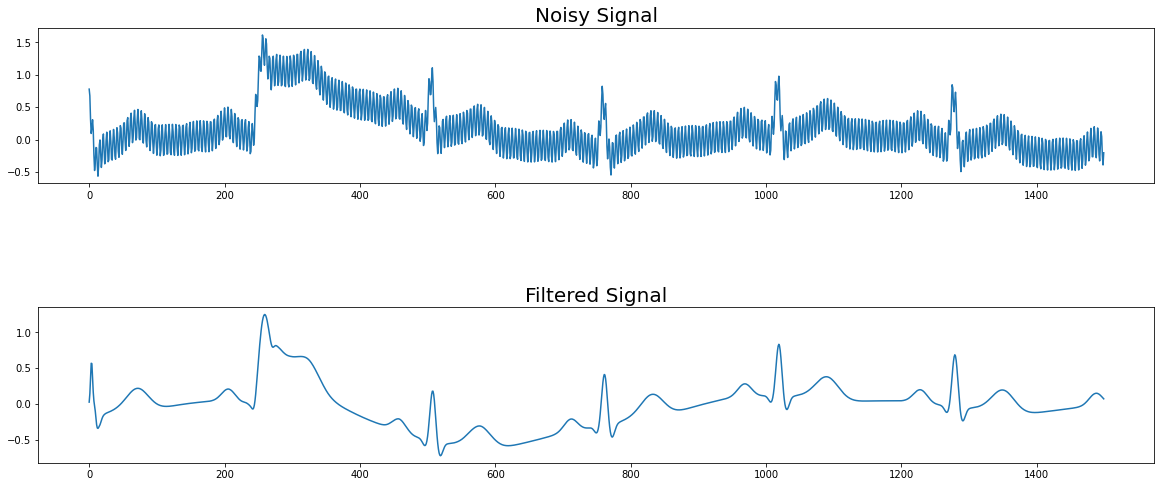

In [85]:
outputSignal = filterNoise(input)

plt.subplot(212)
plt.plot(outputSignal[:1500])
plt.title('Filtered Signal', fontsize=20)
plt.subplot(211)
plt.plot(input[:1500])
plt.title('Noisy Signal', fontsize=20)
plt.subplots_adjust(hspace=0.8)
plt.show()

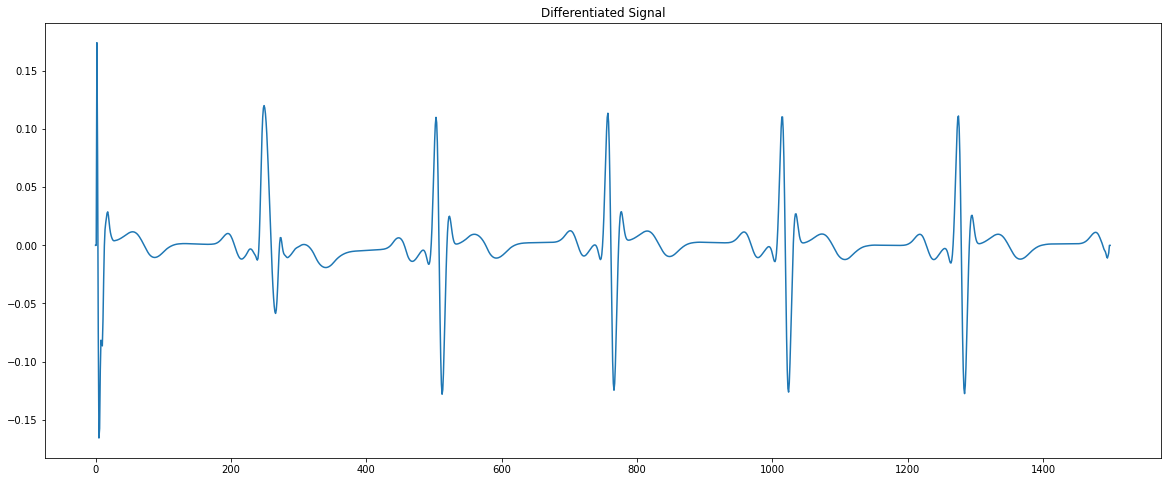

In [86]:
plt.plot(differentiateSignal(filterNoise(input[:1500])))
plt.title("Differentiated Signal")
plt.show()

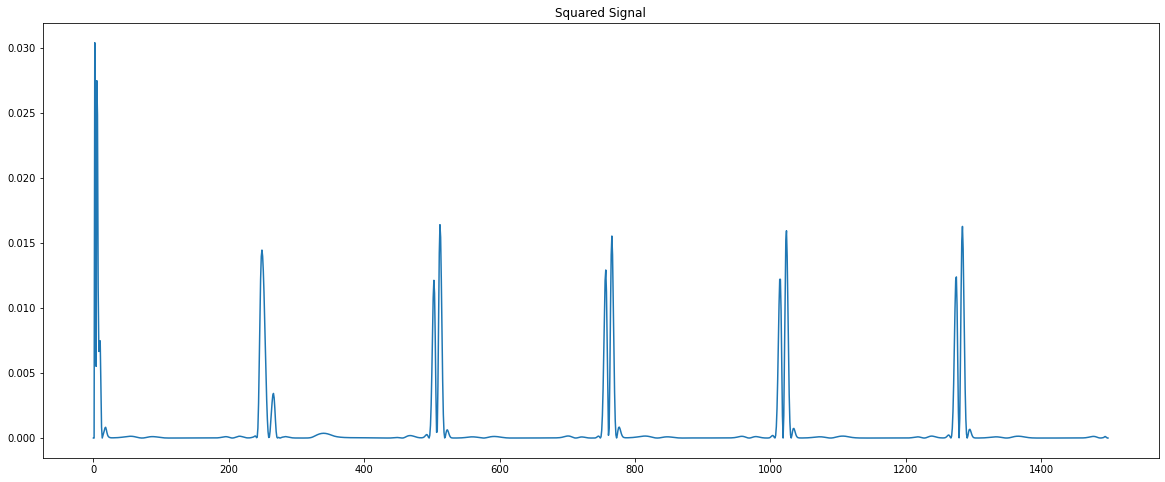

In [87]:
plt.plot(np.square(differentiateSignal(filterNoise(input[:1500]))))
plt.title("Squared Signal")
plt.show()

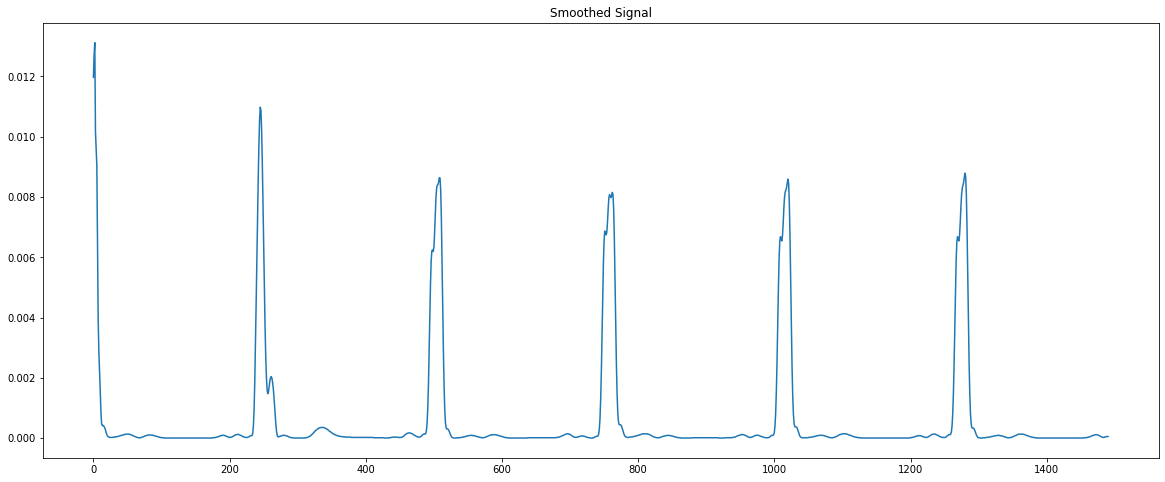

In [88]:
plt.plot(getMovingAverage(np.square(differentiateSignal(filterNoise(input[:1500]))),10))
plt.title("Smoothed Signal")
plt.show()

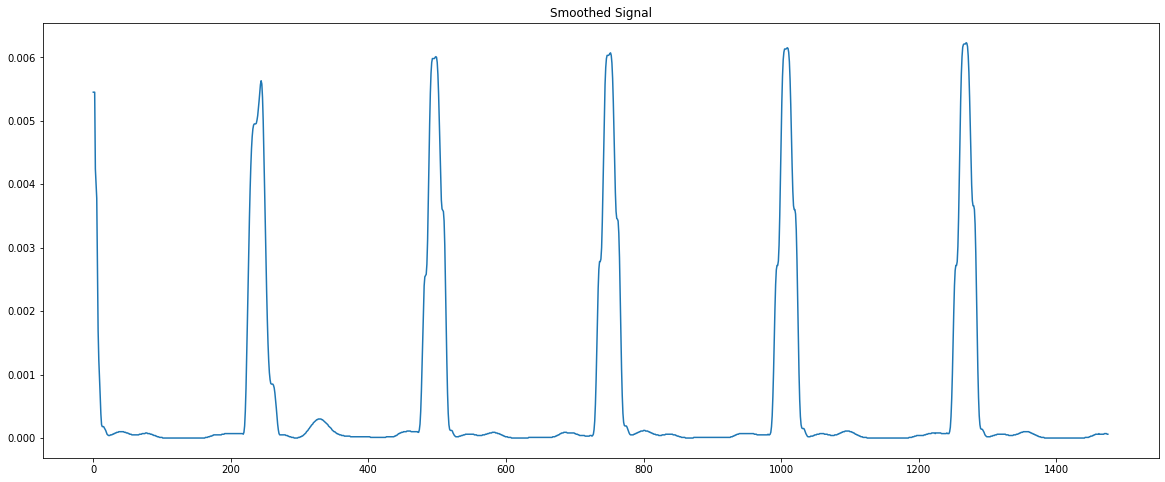

In [89]:
plt.plot(getMovingAverage(np.square(differentiateSignal(filterNoise(input[:1500]))),25))
plt.title("Smoothed Signal")
plt.show()

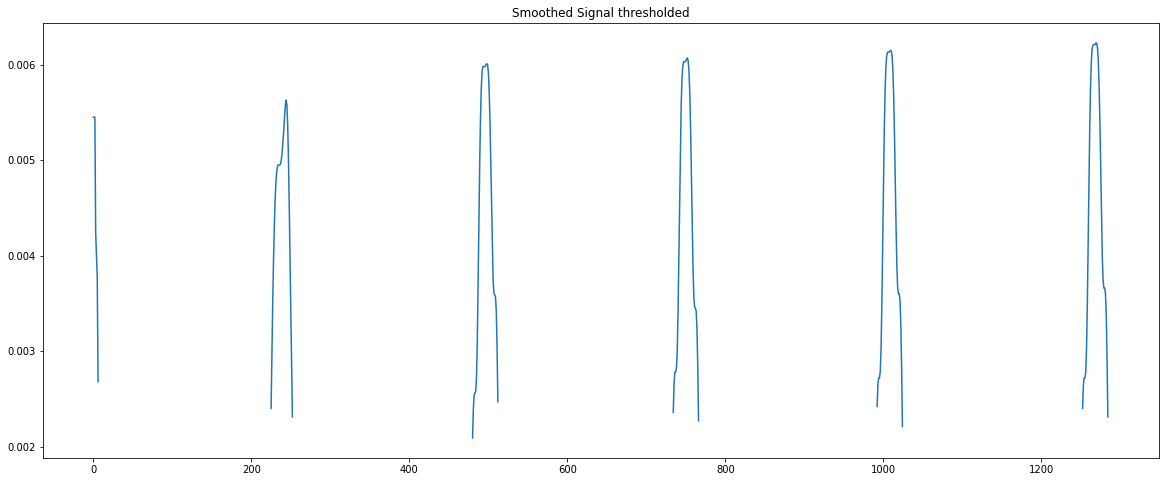

In [90]:
smoothSignal = getMovingAverage(np.square(differentiateSignal(filterNoise(input[:1500]))),25)
smoothSignal = np.array(smoothSignal)
smoothSignal[smoothSignal < (np.nanmax(smoothSignal)/3)] = None
plt.plot(smoothSignal)
plt.title("Smoothed Signal thresholded")
plt.show()

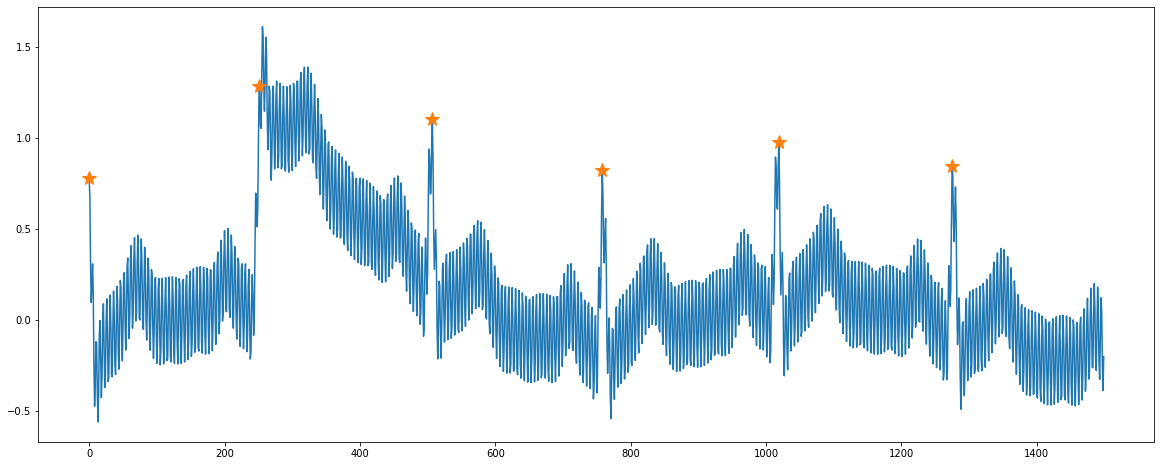

In [91]:
r,rr = detectR(input[:1500],10)
peaks = [None] * 1500
for i in r:
    peaks[i] = input[i]
plt.plot(input[:1500])
plt.plot(peaks, marker="*", markersize=15)
plt.show()

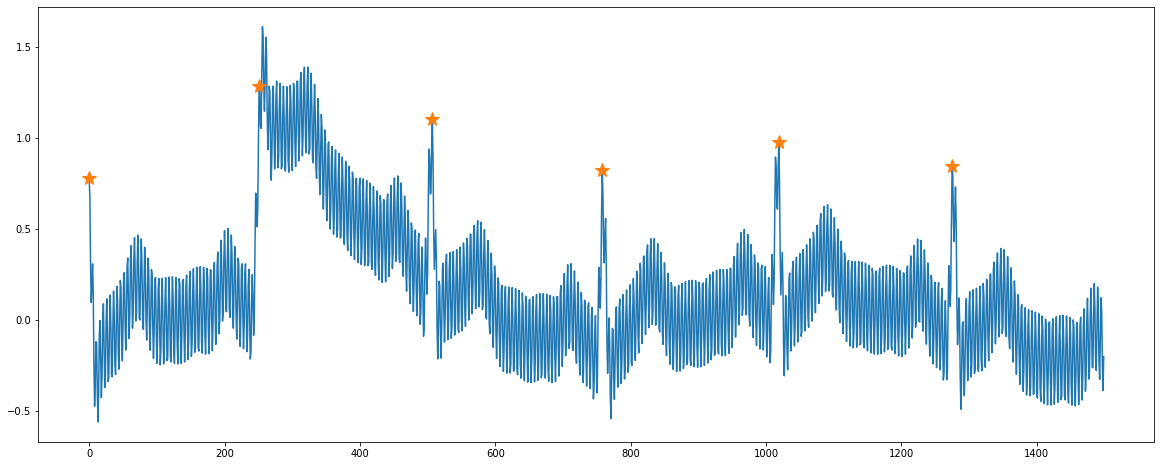

In [92]:
r,rr = detectR(input[:1500],15)
peaks = [None] * 1500
for i in r:
    peaks[i] = input[i]
plt.plot(input[:1500])
plt.plot(peaks, marker="*", markersize=15)
plt.show()

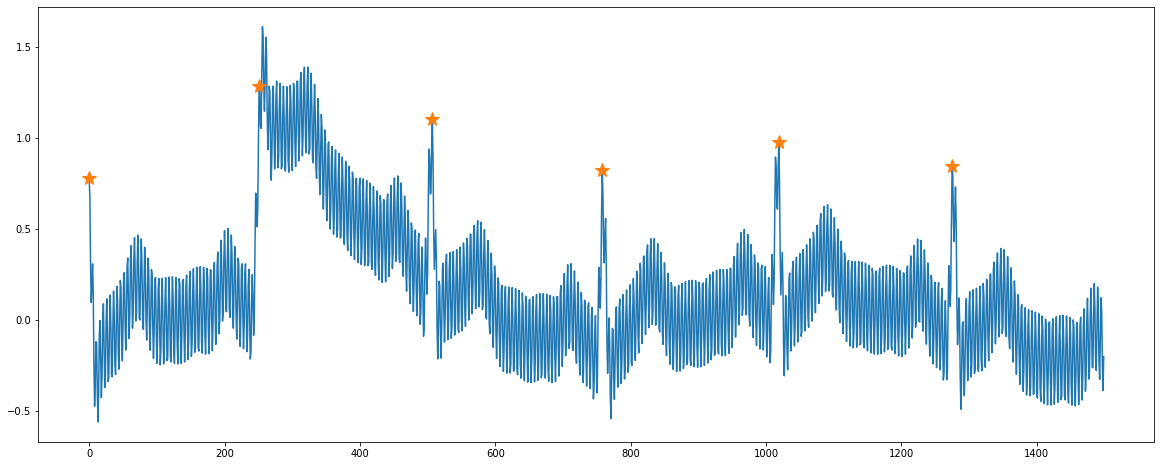

In [93]:
r,rr = detectR(input[:1500],25)
peaks = [None] * 1500
for i in r:
    peaks[i] = input[i]
plt.plot(input[:1500])
plt.plot(peaks, marker="*", markersize=15)
plt.show()

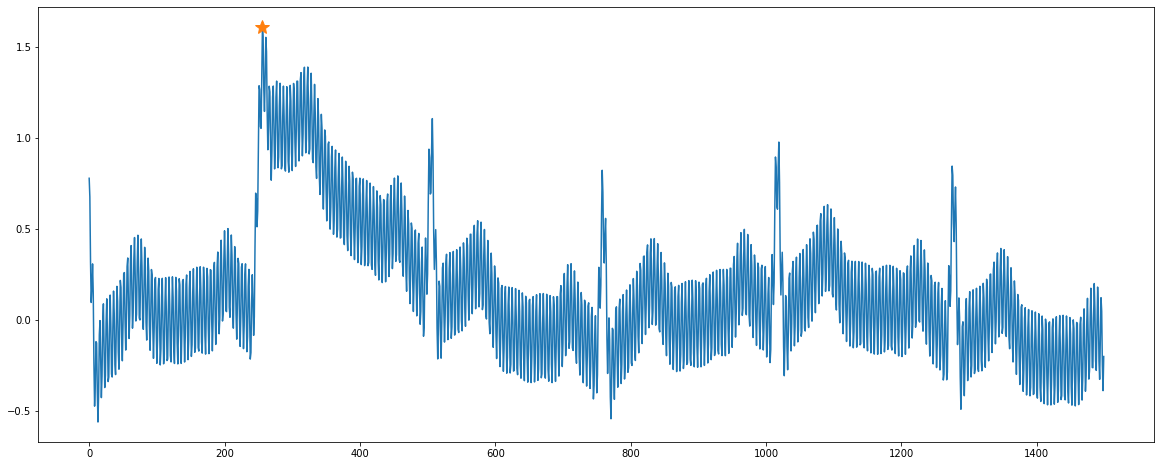

In [94]:
r,rr = detectR(input[:1500],25,False)
peaks = [None] * 1500
for i in r:
    peaks[i] = input[i]
plt.plot(input[:1500])
plt.plot(peaks, marker="*", markersize=15)
plt.show()

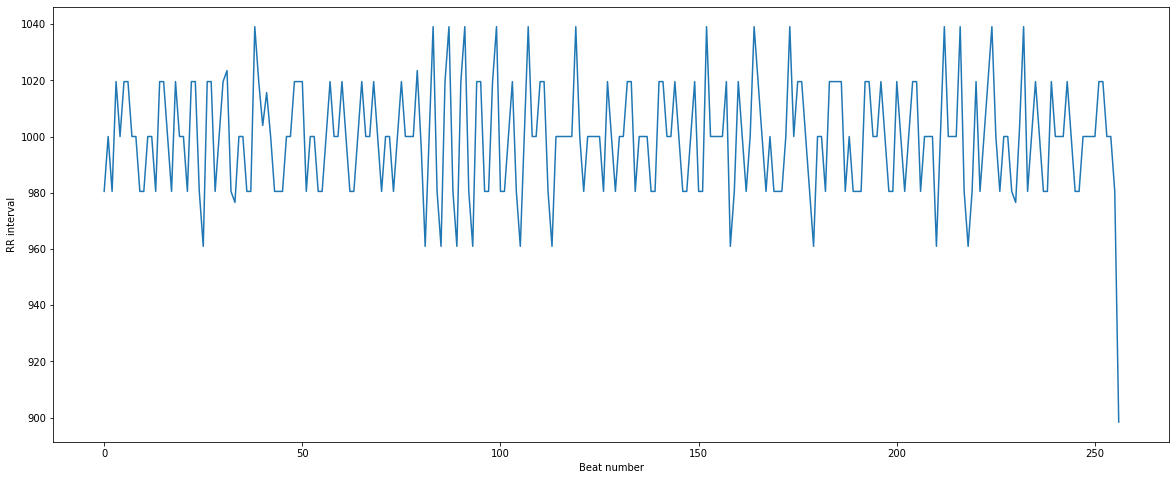

In [95]:
r,rr = detectR(input,25)
plt.plot(rr)
plt.xlabel("Beat number")
plt.ylabel("RR interval")
plt.show()

# Question 2

In [96]:
with open('Data2.txt') as f:
    input2 = f.readlines()
for i in range(len(input2)):
    input2[i] = float(input2[i].replace("\n",""))

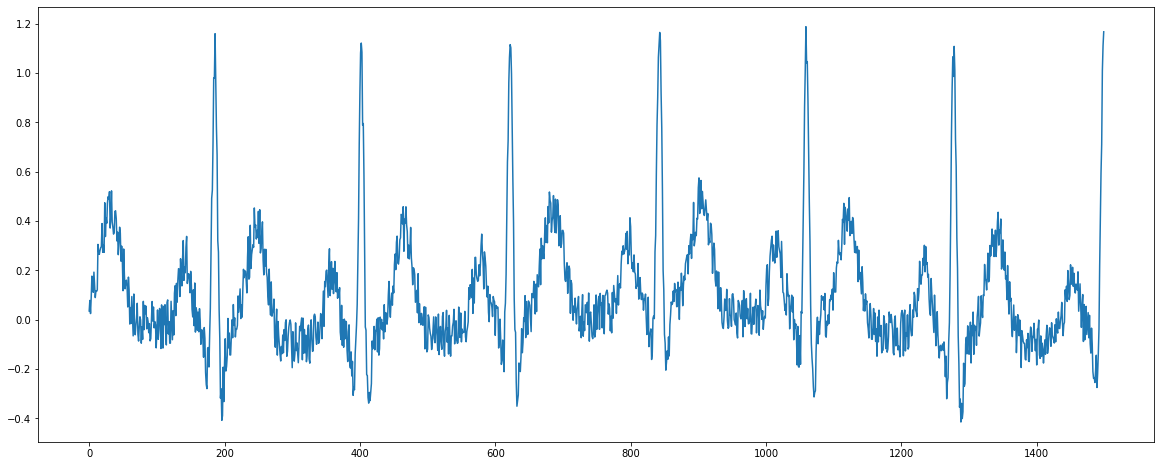

In [97]:
plt.plot(input2[-1500:])
plt.show()

In [98]:
def detectMissingBeats(signal,N):
    r,rr = detectR(signal,N)
    outliers = np.where(rr>np.average(rr)+3*np.std(rr))[0]
    missingBeats = [None] * len(signal)
    for i in outliers:
        missingBeats[int((r[i]+r[i+1])//2)] = np.nanmax(signal)*0.9
    plt.plot(signal[:1500])
    plt.plot(missingBeats[:1500], marker="*", markersize=15)
    plt.show()
    return [x for x in range(len(missingBeats)) if not missingBeats[x] is None]

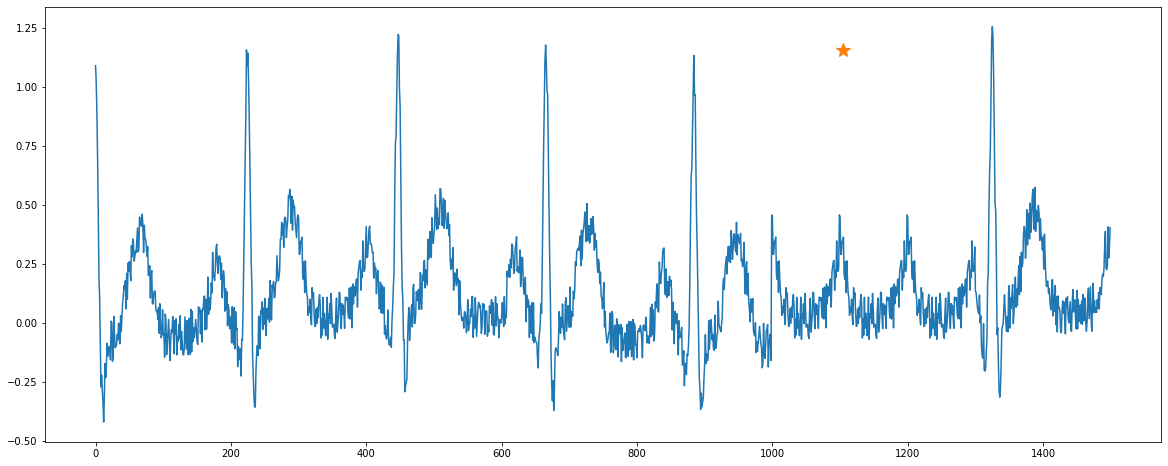

[1104, 2413, 5268]


In [99]:
print(detectMissingBeats(input2,25))